In [56]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
# read the words
words = open('names.txt', 'r').read().splitlines()
len(words), words[:5]

(32033, ['emma', 'olivia', 'ava', 'isabella', 'sophia'])

In [58]:
# build the vocabulary
chars = sorted(list(set(''.join(words))))
s_to_i = {'.' : 0} | {s: i + 1 for i, s in enumerate(chars)}
i_to_s = {i: s for s, i in s_to_i.items()}
vocab_size = len(i_to_s)
print(i_to_s)
print(vocab_size)

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
27


In [59]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [60]:
# build the dataset

block_size = 3 # context length (how many chars to predict next)

def build_dataset(words):
	X, Y = [], []

	for w in words:
		context = [0] * block_size
		for ch in w + '.':
			idx = s_to_i[ch]
			X.append(context)
			Y.append(idx)
			context = context[1:] + [idx]
	
	X = torch.tensor(X)
	Y = torch.tensor(Y)
	print(X.shape, Y.shape)
	return X, Y

n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)
X_train,	Y_train	= build_dataset(words[:n1])		# 80%
X_val,		Y_val	= build_dataset(words[n1:n2])	# 10%
X_test,		Y_test	= build_dataset(words[n2:])		# 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [61]:
for x, y in zip(X_train[:20], Y_train[:20]):
	print(''.join([i_to_s[i.item()] for i in x]), '--->', i_to_s[y.item()])

... ---> y
..y ---> u
.yu ---> h
yuh ---> e
uhe ---> n
hen ---> g
eng ---> .
... ---> d
..d ---> i
.di ---> o
dio ---> n
ion ---> d
ond ---> r
ndr ---> e
dre ---> .
... ---> x
..x ---> a
.xa ---> v
xav ---> i
avi ---> e


In [62]:
class Linear:
	def __init__(self, fan_in, fan_out, bias=True):
		self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
		self.bias = torch.zeros(fan_out) if bias else None
	
	def __call__(self, x):
		self.out = x @ self.weight
		if self.bias is not None:
			self.out += self.bias
		return self.out
	
	def parameters(self):
		return [self.weight] + ([] if self.bias is None else [self.bias])

In [63]:
class BatchNorm1d:
	def __init__(self, dim, eps=1e-5, momentum=0.1):
		self.eps = eps
		self.momentum = momentum
		self.training = True
		# parameters trained with backprop
		self.gamma = torch.ones(dim)
		self.beta = torch.zeros(dim)
		# running statistics
		self.running_mean = torch.zeros(dim)
		self.running_var = torch.ones(dim)
	
	def __call__(self, x):
		# calculate the forward pass
		if self.training:
			mean = x.mean(0, keepdim=True) # batch mean
			var = x.var(0, keepdim=True) # batch variance
		else:
			mean = self.running_mean
			var = self.running_var
		x_hat = (x - mean) / torch.sqrt(var + self.eps)
		self.out = self.gamma * x_hat + self.beta
		# update running statistics
		if self.training:
			with torch.no_grad():
				self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
				self.running_var = (1 - self.momentum) * self.running_var + self.momentum * var
		return self.out
	
	def parameters(self):
		return [self.gamma, self.beta]

In [64]:
class Tanh:
	def __call__(self, x):
		self.out = torch.tanh(x)
		return self.out
	def parameters(self):
		return []

In [65]:
class Embedding:
	def __init__(self, num_embeddings, embedding_dim):
		self.weight = torch.randn((num_embeddings, embedding_dim))

	def __call__(self, x):
		self.out = self.weight[x]
		return self.out

	def parameters(self):
		return [self.weight]

In [66]:
class Flatten:
	def __call__(self, x):
		self.out = x.view(x.shape[0], -1)
		return self.out

	def parameters(self):
		return []

In [67]:
class Sequential:
	def __init__(self, layers):
		self.layers = layers
	
	def __call__(self, x):
		for layer in self.layers:
			x = layer(x)
		self.out = x
		return self.out
	
	def parameters(self):
		return [p for layer in self.layers for p in layer.parameters()]

In [68]:
torch.manual_seed(42);

In [69]:
n_embd = 10 # embedding size
n_hidden = 200 # hidden layer size

model = Sequential([
	Embedding(vocab_size, n_embd),
	Flatten(),
	Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
	Linear(n_hidden, vocab_size),
])

with torch.no_grad():
	model.layers[-1].weight *= 0.1 # make last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
	p.requires_grad = True

12097


In [70]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

	# minibatch
	minibatch = torch.randint(0, X_train.shape[0], (batch_size,))
	Xb, Yb = X_train[minibatch], Y_train[minibatch]

	# forward pass
	logits = model(Xb)
	loss = F.cross_entropy(logits, Yb) # loss function

	# backward pass
	for p in parameters:
		p.grad = None
	loss.backward()

	# update: simple SGD
	lr = 0.1 if i < 100000 else 0.01
	for p in parameters:
		p.data += -lr * p.grad
	
	# track stats
	if i % 10000 == 0:
		print(f'{i:7d}/ {max_steps:7d}: {loss.item():.4f}')
	lossi.append(loss.log10().item())

	# break

      0/  200000: 3.2966
  10000/  200000: 2.2322
  20000/  200000: 2.4111
  30000/  200000: 2.1004
  40000/  200000: 2.3157
  50000/  200000: 2.2104
  60000/  200000: 1.9653
  70000/  200000: 1.9767
  80000/  200000: 2.6738
  90000/  200000: 2.0837
 100000/  200000: 2.2730
 110000/  200000: 1.7087
 120000/  200000: 2.3243
 130000/  200000: 2.2512
 140000/  200000: 2.0113
 150000/  200000: 1.8195
 160000/  200000: 1.7985
 170000/  200000: 2.2206
 180000/  200000: 2.0566
 190000/  200000: 2.1030


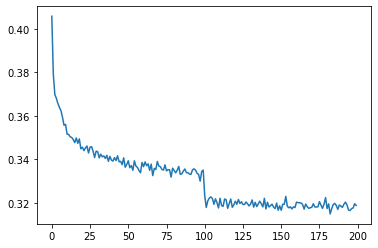

In [71]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [72]:
for layer in model.layers:
	layer.training = False

In [73]:
# evaluate the loss
@torch.no_grad()
def split_loss(split):
	x, y = {
		'train': (X_train, Y_train),
		'val': (X_val, Y_val),
		'test': (X_test, Y_test)
	}[split]
	logits = model(x)
	loss = F.cross_entropy(logits, y)
	print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0621414184570312
val 2.109346389770508


In [74]:
# sample from model

for _ in range(20):
	out = []
	context = [0] * block_size
	while True:
		logits = model(torch.tensor([context]))
		probs = F.softmax(logits, dim=1)
		ix = torch.multinomial(probs, num_samples=1).item()
		context = context[1:] + [ix]
		out.append(ix)
		if ix == 0:
			break
	
	print(''.join(i_to_s[i] for i in out[:-1]))

damiara
alyzah
faraliza
francy
roy
lorie
rossot
emon
catine
aub
alith
sira
liza
jah
grancealynna
jamaur
ben
quan
torie
coria
